## Applied Data Science Capstone Project - Battle of Neighborhoods

### Recommend location to open a Yoga Studio in Toronto

In [340]:
#import all required libraries

from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
from IPython.display import display_html

!pip install folium
import folium

from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
from geopy.geocoders import Nominatim 

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries import done')

Libraries import done


#### Step 1a - Get postal codes of Canada by scapping wikipedia page

In [341]:
#scrap wikipedia page
page_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(page_url).text

soup=BeautifulSoup(source,'xml')

tab = str(soup.table)

In [342]:
#Convert html to Pandas dataframe to enable cleaning and processing of data
dfs = pd.read_html(tab)
df=dfs[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


#### Step 1b - Data Preprocessing and cleaning

In [343]:
#Ignore cells with borough that are 'Not assigned' so that we only process the rows with an assigned borough
df1 = df[df.Borough != 'Not assigned']

#Combine neighbourhoods with same Postal Code
df2 = df1.groupby(['Postal Code','Borough'], sort=False).agg(', '.join)
df2.reset_index(inplace=True)

#Replace data where neighbourhood that are 'Not assigned' with the name of Borough
df2['Neighbourhood'] = np.where(df2['Neighbourhood'] == 'Not assigned',df2['Borough'], df2['Neighbourhood'])

df2.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [344]:
#display shape of the dataframe
df2.shape

(103, 3)

#### Step 2 - Append Latitude and Longitude to neighbourhoods

In [345]:
#Get lattitude and longitude by importing provided link to csv
la_lo = pd.read_csv('https://cocl.us/Geospatial_data')
la_lo.head()

#assign latitude and longitude to neighbourhoods in canada by merging two dataframes
df_canada_geo = pd.merge(df2, la_lo, on ='Postal Code')
df_canada_geo.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [346]:
df_canada_geo.groupby('Borough').count()['Neighbourhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighbourhood, dtype: int64

#### Get co-ordinates of Toronto

In [347]:
#get data that has Borough as Toronto
df_toronto_geo = df_canada_geo[df_canada_geo['Borough'].str.contains('Toronto',regex=False)]
df_toronto_geo.groupby('Borough').count()['Neighbourhood']

Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
West Toronto         6
Name: Neighbourhood, dtype: int64

In [348]:
# Get latitude and Longitude for Toronto
geolocator = Nominatim (user_agent="ny_explorer")
location = geolocator.geocode('Toronto')
lat_toronto = location.latitude
lng_toronto = location.longitude
print (lat_toronto)
print (lng_toronto)

43.6534817
-79.3839347


In [349]:
#Generate maps to visualize neighborhoods and show how they cluster together
map_toronto = folium.Map(location=[lat_toronto,lng_toronto],zoom_start=10)

for lat,lng,borough,neighbourhood in zip(df_toronto_geo['Latitude'],df_toronto_geo['Longitude'],df_toronto_geo['Borough'],df_toronto_geo['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color='blue',
    fill=True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(map_toronto)
map_toronto

#### Step 3 - Get venue details of Toronto

In [350]:
#Foursquare details
CLIENT_ID = 'TTD0JRI5KTCMWSCYVLBAUCKHXMGEHUQCTNI1A0TV1WS2N21W' #  Client ID
CLIENT_SECRET = 'O0H4QW350PLZUGEKTIDU1KPCOZLFFEOYJ0SIH1BJAIHVIA3V' # Client Secret
VERSION = '20200804' # Foursquare API version
LIMIT = 150 # limit of number of venues returned 
RADIUS = 500 #  radius

In [351]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
   
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [352]:
toronto_venues = getNearbyVenues(names=df_toronto_geo['Neighbourhood'],
                                latitudes=df_toronto_geo['Latitude'],
                                longitudes=df_toronto_geo['Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West, Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
R

In [353]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Berczy Park,57,57,57,57,57,57
"Brockton, Parkdale Village, Exhibition Place",25,25,25,25,25,25
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",17,17,17,17,17,17
Central Bay Street,62,62,62,62,62,62
Christie,16,16,16,16,16,16
Church and Wellesley,79,79,79,79,79,79
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,36,36,36,36,36,36


In [354]:
toronto_venues.groupby('Venue Category').count()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Adult Boutique,1,1,1,1,1,1
Afghan Restaurant,1,1,1,1,1,1
Airport,1,1,1,1,1,1
Airport Food Court,1,1,1,1,1,1
Airport Lounge,2,2,2,2,2,2
...,...,...,...,...,...,...
Video Game Store,2,2,2,2,2,2
Vietnamese Restaurant,7,7,7,7,7,7
Wine Bar,9,9,9,9,9,9


In [355]:
"Yoga Studio" in toronto_venues['Venue Category'].unique()

True

In [356]:
#perform one hot encoding for getting dummies of the venue category
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighbourhoods'] = toronto_venues['Neighbourhood'] 
to_onehot.set_index('Neighbourhoods', inplace=True)

to_onehot.reset_index(inplace=True)
print(to_onehot.shape)
to_onehot.head()

(1622, 237)


,Neighbourhoods,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


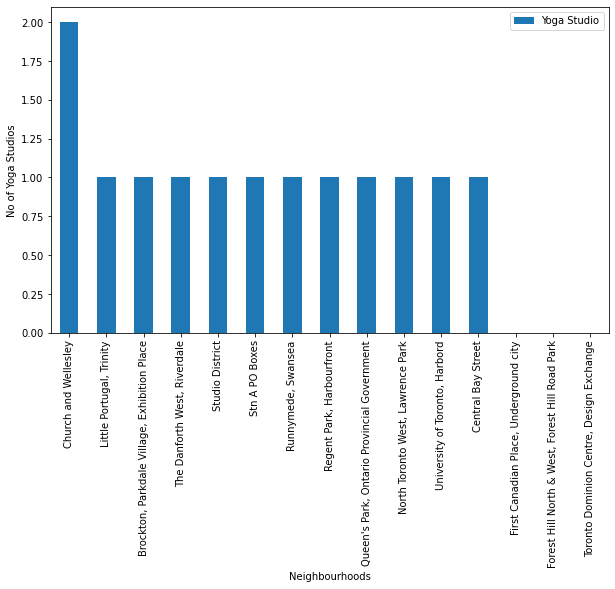

In [357]:
#visualize max number of Yoga Studio
graph = pd.DataFrame(to_onehot.groupby('Neighbourhoods')['Yoga Studio'].sum())
graph = graph.sort_values(by='Yoga Studio', ascending=False)
graph.iloc[:15].plot(kind='bar', figsize=(10,6))
plt.xlabel('Neighbourhoods')
plt.ylabel('No of Yoga Studios')
plt.show()

In [358]:
#Calculate mean of all venue groups by their neighbourhoods
to_grouped = to_onehot.groupby(["Neighbourhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped.head()

(39, 237)


,Neighbourhoods,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.017544,0.0,0.0,0.000000,0.0,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.040000
2,"Business reply mail Processing Centre, South C...",0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0,0.058824,0.058824,0.117647,0.176471,0.117647,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
4,Central Bay Street,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.016129,0.0,0.0,0.016129,0.0,0.016129


In [359]:
# extract only the neighbourhoods and Yoga Studio column for further analysis
Yoga_Studio = to_grouped[["Neighbourhoods","Yoga Studio"]]
print(Yoga_Studio.shape)
Yoga_Studio.head()

(39, 2)


,Neighbourhoods,Yoga Studio
0,Berczy Park,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.040000
2,"Business reply mail Processing Centre, South C...",0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000
4,Central Bay Street,0.016129


In [360]:
toronto_clustering = Yoga_Studio.drop('Neighbourhoods', 1)

#### Step 4 - Clustering using K-means

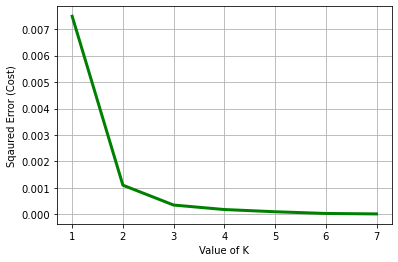

In [361]:
# find best K for Kmeans
cost =[] 
for i in range(1, 8): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(toronto_clustering) 
      
    # calculates squared error for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 8), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.grid()
plt.show() # clear the plot

In [362]:
#using K-means for the clsutering of the neighbourhoods
#according to the graph above the best value of K is 3
k=3
kmeans1 = KMeans(n_clusters = k,random_state=0).fit(toronto_clustering)
kmeans1.labels_

array([0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1], dtype=int32)

In [363]:
to_merged = Yoga_Studio.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans1.labels_
to_merged.head()

,Neighbourhoods,Yoga Studio,Cluster Labels
0,Berczy Park,0.000000,0
1,"Brockton, Parkdale Village, Exhibition Place",0.040000,2
2,"Business reply mail Processing Centre, South C...",0.000000,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.000000,0
4,Central Bay Street,0.016129,1


In [364]:
# join to_merged with toronto venue to add latitude/longitude for each neighborhood
to_merged = to_merged.join(toronto_venues.set_index("Neighbourhood"), on="Neighbourhoods")

print(to_merged.shape)
to_merged.head()

(1622, 9)


,Neighbourhoods,Yoga Studio,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.0,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
0,Berczy Park,0.0,0,43.644771,-79.373306,LCBO,43.642944,-79.372440,Liquor Store
0,Berczy Park,0.0,0,43.644771,-79.373306,Fresh On Front,43.647815,-79.374453,Vegetarian / Vegan Restaurant
0,Berczy Park,0.0,0,43.644771,-79.373306,Meridian Hall,43.646292,-79.376022,Concert Hall
0,Berczy Park,0.0,0,43.644771,-79.373306,Hockey Hall Of Fame (Hockey Hall of Fame),43.646974,-79.377323,Museum


In [365]:
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.head()

,Neighbourhoods,Yoga Studio,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Berczy Park,0.0,0,43.644771,-79.373306,The Keg Steakhouse + Bar - Esplanade,43.646712,-79.374768,Restaurant
25,"Richmond, Adelaide, King",0.0,0,43.650571,-79.384568,The Burger's Priest,43.648643,-79.387539,Fast Food Restaurant
25,"Richmond, Adelaide, King",0.0,0,43.650571,-79.384568,Brick Street Bakery,43.648815,-79.380605,Bakery
25,"Richmond, Adelaide, King",0.0,0,43.650571,-79.384568,King Taps,43.648476,-79.382058,Gastropub
25,"Richmond, Adelaide, King",0.0,0,43.650571,-79.384568,Pilot Coffee Roasters,43.648835,-79.380936,Coffee Shop


In [366]:
# create map
map_clusters = folium.Map(location=[lat_toronto, lng_toronto],zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for la, lo, cluster in zip(to_merged['Neighbourhood Latitude'], to_merged['Neighbourhood Longitude'], to_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster) + " " + str(la) + " " + str(lo) , parse_html=True)
    folium.CircleMarker(
        [la, lo],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
    
map_clusters

#### Examine Clusters 

In [367]:
#Cluster 0
to_merged.loc[(to_merged['Cluster Labels'] ==0) & (to_merged['Venue Category'] == 'Yoga Studio') ]

,Neighbourhoods,Yoga Studio,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
31,Stn A PO Boxes,0.010204,0,43.646435,-79.374846,Bikram Yoga Centre,43.649214,-79.375229,Yoga Studio


In [368]:
#Cluster 1
to_merged.loc[(to_merged['Cluster Labels'] ==1) & (to_merged['Venue Category'] == 'Yoga Studio') ]

,Neighbourhoods,Yoga Studio,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
32,Studio District,0.027778,1,43.659526,-79.340923,Spirit Loft Yoga,43.663548,-79.341333,Yoga Studio
4,Central Bay Street,0.016129,1,43.657952,-79.387383,The Yoga Sanctuary,43.661499,-79.383636,Yoga Studio
38,"University of Toronto, Harbord",0.030303,1,43.662696,-79.400049,Sivananda Yoga Centre,43.662754,-79.402951,Yoga Studio
36,"The Danforth West, Riverdale",0.023256,1,43.679557,-79.352188,Moksha Yoga Danforth,43.677622,-79.352116,Yoga Studio
24,"Regent Park, Harbourfront",0.021739,1,43.654260,-79.360636,The Yoga Lounge,43.655515,-79.364955,Yoga Studio
19,"Little Portugal, Trinity",0.022727,1,43.647927,-79.419750,YogaSpace,43.647607,-79.420133,Yoga Studio
23,"Queen's Park, Ontario Provincial Government",0.031250,1,43.662301,-79.389494,The Yoga Sanctuary,43.661499,-79.383636,Yoga Studio
6,Church and Wellesley,0.025316,1,43.665860,-79.383160,Bikram Yoga Yonge,43.668205,-79.385780,Yoga Studio
6,Church and Wellesley,0.025316,1,43.665860,-79.383160,The Yoga Sanctuary,43.661499,-79.383636,Yoga Studio
28,"Runnymede, Swansea",0.025641,1,43.651571,-79.484450,(The New) Moksha Yoga Bloor West,43.648658,-79.485242,Yoga Studio


In [369]:
#Cluster 2
to_merged.loc[(to_merged['Cluster Labels'] ==2) & (to_merged['Venue Category'] == 'Yoga Studio') ]

,Neighbourhoods,Yoga Studio,Cluster Labels,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,"Brockton, Parkdale Village, Exhibition Place",0.040000,2,43.636847,-79.428191,Pure Yoga Toronto,43.63733,-79.423800,Yoga Studio
21,"North Toronto West, Lawrence Park",0.052632,2,43.715383,-79.405678,Barreworks,43.71407,-79.400109,Yoga Studio
